notebook: 1.2-becker-data-modelling_XGBoost.ipynb

author: Jonathan Becker  

**Updated:** 2025-12-09
**Purpose:** Train an xgboost model on the aggregated dataset after feature engineering
**Summary:** This notebook prepares the concatenated dataset, trains the model, and evaluates its performance. It also explores parameter optimization to improve the model’s accuracy and robustness.


In [5]:
# classic packages
import pandas as pd
import numpy as np
from joblib import dump, load

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# make custom libraries importable
import sys
sys.path.append('../../library')

# pipeline compatibel classes
#from road_accidents_pipeline import ModalityReducer              # bundle classes of categorical features together to higher-tier classes to reduce dimensionality
#from road_accidents_pipeline import RemoveIrrelevantCols         # removes some unnecessary columns
from road_accidents_pipeline import ConditionalMultiQuantImputer # impute missing values of quantiative variables via distr. on cat var
from road_accidents_pipeline import ConditionalCatImputer        # impute missing values of categorcial variables on target distribution
from road_accidents_pipeline import AggrLocaSplit                # aggregation of loca intersections incl. oneHotEncoding 
from road_accidents_pipeline import SupervisedEncoderWrapper     # wrapper for supervised encoders like CatBoostEncoder or TargetEncoder to make it work in pipeline
from road_accidents_pipeline import RemoveIdCols                 # removes ind_temp_id and acc_num after aggregation
from road_accidents_pipeline import TrigonometricEncoder         # encoding for cyclic variables lice acc_month or acc_hour
from road_accidents_pipeline import SafeColumnSelector           # makes sure only to use existing columns in pipeline

# scaler
from sklearn.preprocessing import MinMaxScaler

# encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from category_encoders import TargetEncoder, CatBoostEncoder

# train_test_split
from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from sklearn.metrics import make_scorer, f1_score, recall_score
from sklearn.decomposition import PCA
#from sklearn.inspection import permutation_importance

import shap

# pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# model classifier
from sklearn.ensemble import RandomForestClassifier

# hyperparameter optimization
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# little helper
from cleaning_utils import distinguish_cols
import time

# XGBoost classifier
from xgboost import XGBClassifier

# google cloud storage
import gc_storage as gcs


from google.cloud import storage


/opt/homebrew/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [6]:
# init Google Cloud storage
bucket_name='sep25-bds-road-accidents'
key_path='../../auth/fiery-glass-478009-t8-18a81c8cbe63.json'

bucket = gcs.init_bucket( bucket=bucket_name,
                                 json_key_path=key_path )
gcs.list_bucket( bucket=bucket,
                 remote_folder='2_preprocessing' )

Initialized sep25-bds-road-accidents
Number of blobs: [35]
data/processed/2_preprocessing/
data/processed/2_preprocessing/0.1-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.2-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.3-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/0.4-munz-data-preprocessing_locations.joblib
data/processed/2_preprocessing/1.0-becker-data-preprocessing_usagers.joblib
data/processed/2_preprocessing/1.0-leibold-data-preprocessing_aggr.gc
data/processed/2_preprocessing/1.0-leibold-data-preprocessing_aggr.joblib
data/processed/2_preprocessing/1.0-leibold-data-preprocessing_vehicles.joblib
data/processed/2_preprocessing/1.0-munz-acc-municipality_X_test_uniques_lookup_table.gc
data/processed/2_preprocessing/1.0-munz-acc-municipality_X_train_uniques_lookup_table.gc
data/processed/2_preprocessing/1.0-munz-preprocessing-X_test.gc
data/processed/2_preprocessing/1.0-munz-preprocessing-X_test_proce

In [7]:
# downlad aggregated dataset and pipeline

df = gcs.download( bucket=bucket,
                   remote_path='2_preprocessing/1.0-leibold-data-preprocessing_aggr.joblib')

Downloaded data/processed/2_preprocessing/1.0-leibold-data-preprocessing_aggr.joblib to
 ../../data/processed/2_preprocessing/1.0-leibold-data-preprocessing_aggr.joblib


In [8]:
df.shape

(692159, 45)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 692159 entries, 0 to 733874
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   acc_num                 692159 non-null  int64         
 1   ind_place               692159 non-null  int64         
 2   ind_cat                 692159 non-null  int64         
 3   ind_severity            692159 non-null  int64         
 4   ind_sex                 692159 non-null  int64         
 5   ind_trip                692159 non-null  int64         
 6   ind_secu1               691305 non-null  Int64         
 7   ind_secu2               415207 non-null  Int64         
 8   ind_location            379506 non-null  Int64         
 9   ind_action              409030 non-null  Int64         
 10  ind_year                692159 non-null  int64         
 11  ind_age                 692159 non-null  Int64         
 12  ind_age_group           692159 non-

In [10]:
# Split data into features and target
X = df.drop(columns=['ind_severity'],axis=1)
y= df['ind_severity']
print( f"target distribution:\n{y.value_counts()}\n" )
print( f"target distribution:\n{y.value_counts(normalize=True).round(3)}" )

# Remap 
if np.min(y) == 1:
    y = y - 1

print("After:", np.unique(y))

target distribution:
ind_severity
1    285859
2    280987
3    106958
4     18355
Name: count, dtype: int64

target distribution:
ind_severity
1    0.413
2    0.406
3    0.155
4    0.027
Name: proportion, dtype: float64
After: [0 1 2 3]


In [11]:
# train test split with stratification 
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                     test_size=0.3,
                                                     random_state=123,
                                                     stratify=y)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (484511, 44)
y_train shape: (484511,)
X_test shape: (207648, 44)
y_test shape: (207648,)


In [12]:
missing_vars = X_train.isna().sum()
missing_vars = missing_vars[missing_vars > 0]
print(missing_vars)

ind_secu1                    585
ind_secu2                 193622
ind_location              218771
ind_action                198090
acc_ambient_lightning          8
acc_atmosphere                26
acc_intersection              19
acc_collision_type          2651
veh_impact                   189
veh_maneuver               27969
loca_road_lanes             6787
loca_road_view                40
loca_road_surface_cond        86
loca_max_speed              6799
loca_max_speed_dif          6799
dtype: int64


In [13]:
mapping_dicts = {
    "acc_ambient_lightning": {
        1: 1,  # day
        2: 2,  # twilight
        3: 3, 4: 3, 5: 3  # night
    },

    "acc_intersection": {
        1: 1,  # no intersection
        2: 2, 3: 2, 4: 2,  # simple / standard intersection
        6: 3,  # roundabout
        5: 4, 7: 4, 8: 4, 9: 4  # other
    },

    "acc_atmosphere": {
        1: 1,  # clear
        2: 2, 3: 2,  # rainy
        8: 3,  # cloudy
        4: 4, 5: 4, 6: 4, 7: 4, 9: 4  # adverse / special
    },

    "acc_collision_type": {
        1: 1,  # frontal
        2: 2,  # rear
        3: 3,  # side
        4: 4, 5: 4, 6: 4, 7: 4  # multi / chain / other
    },

    "ind_place": {
        1: 1,  # driver
        **{i: 2 for i in range(2, 10)},  # passenger
        10: 3  # pedestrian / external
    },

    "ind_cat": {
        1: 1,  # driver
        2: 2,  # passenger
        3: 3, 4: 3  # pedestrian
    },

    "ind_sex": {
        1: 1,  # male
        2: 2,  # female
        -1: 2  # female (wrong/missing recoded)
    },

    "ind_trip": {
        1: 1, 2: 1,  # commuting
        3: 2,  # shopping
        4: 3,  # professional
        5: 4,  # leisure
        0: 5, 9: 5  # other
    },

    "ind_secu1": {
        0: 0,  # no equipment
        1: 1,  # seatbelt
        2: 2,  # helmet
        3: 3, 4: 3, 9: 3,  # other / child / vest
        8: 4, -1: 4  # unknown / not reported
    },

    "veh_cat": {
        10: 1, 7: 1,  # light vehicles (car)
        2: 2, 31: 2, 32: 2, 34: 2, 35: 2, 36: 2, 41: 2, 42: 2, 43: 2, 33: 2, 30: 2,  # 2-wheeler
        80: 3, 1: 3,  # bicycle / E-bike
        13: 4, 15: 4, 38: 4, 39: 4, 40: 4, 14: 4, 37: 4,  # heavy / public vehicles
        60: 5, 50: 5,  # micromobility (EDP)
        3: 6, 0: 6, 17: 6, 99: 6, 16: 6, 20: 6, 21:6  # other
    },

    "veh_fixed_obstacle": {
        3: 1, 7: 1, 9: 1, 10: 1, 11: 1, 12: 1, 14: 1, 15: 1, 16: 1, 1: 1, 2: 1, 4: 1, 5: 1, 6: 1,  # vehicle / barrier / wall
        8: 2, 13: 2, 17: 2,  # pole / ditch / culvert
        0: 0  # no fixed obstacle
    },

    "veh_moving_obstacle": {
        1: 1,  # pedestrian
        2: 2,  # vehicle
        4: 3, 5: 3, 6: 3, 9: 3,  # other
        0: 0  # none
    },

    "veh_impact": {
        1: 1, 2: 1, 3: 1,  # front
        4: 2, 5: 2, 6: 2,  # rear
        7: 3, 8: 3,  # side
        9: 4,  # multiple / roll-over
        0: 0  # no impact
    },

    "veh_maneuver": {
        1: 1, 2: 1,  # straight / same lane
        9: 2, 11: 2, 13: 2, 12: 2, 14: 2,  # lane change / offset
        15: 3, 16: 3,  # turning
        5: 4, 17: 4, 19: 4, 18: 4,  # risky maneuvers
        23: 5,  # stopped
        26: 6, 98: 6, 99: 6, 4: 6, 10: 6, 20: 6, 22: 6, 24: 6, 3: 6, 6: 6, 7: 6, 8: 6, 21: 6, 25: 6,  # other maneuvers
        0: 0  # unknown
    },

    "veh_motor": {
        -1: 0, 0: 0,  # missing / unknown
        1: 1, 2: 1,  # combustion / hybrid
        3: 2, 4: 2, 6: 2,  # electric / alt-power
        5: 3  # human-powered
    },

    # keep as is
    "loca_road_cat": {
        1: 1,
        2: 2,
        3: 3,
        4: 4,
        5: 5,
        6: 6,
        7: 7,
        8: 8    
    },

    # keep as is
    "loca_traffic_circul": {
        0: 0,
        1: 1,
        2: 2,
        3: 3,
        4: 4                      
    },

    "loca_road_gradient": {
        0: 0,       # unknown / missing
        1: 1, 2: 1, # flat / slope
        3: 2, 4: 2  # top / bottom
    },

    "loca_road_view": {
        0: 0,       # unknown
        1: 1,       # straight
        2: 2, 3: 2, # curve
        4: 3        # s-shape
    },

    "loca_road_surface_cond": {
        0: 0, 9: 0,                         # unknown / other
        1: 1, 2: 1,                         # typical (normal / wet)
        3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2  # hazardous (water / snow / mud / ice / oil)
    },

    "loca_accident": {
        0: 0,       # none / unknown
        1: 1, 2: 1, # on roadway
        3: 2,       # roadside (verge)
        4: 3, 5: 3, # pedestrian areas
        6: 4, 7: 4  # other special lanes
    },

  
}

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
class ModalityReducer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to reduce categorical modalities
    using predefined mapping dictionaries.
    """

    def __init__(self, mapping_dicts=None):
        self.mapping_dicts = mapping_dicts if mapping_dicts is not None else {}

    def fit(self, X, y=None):
        # Nothing to learn, just return self
        return self

    def transform(self, X):
        X = X.copy()

        # Apply mappings for categorical variables
        for col, mapping in self.mapping_dicts.items():
            if col in X.columns:
                X[col] = X[col].map(mapping).fillna(X[col])

        return X

In [15]:
class RemoveIrrelevantCols(BaseEstimator, TransformerMixin):
    """
    Transformer to remove unnecessary columns from the road accidents DataFrame.
    If a column does not exist, it will be ignored and a warning printed.
    """

    def __init__(self, cols_to_drop=None, verbose=True):
        # Default columns to drop if none provided
        if cols_to_drop is None:
            cols_to_drop = [
    "veh_id",
    "acc_date",
    "acc_long",
    "acc_lat",
    "acc_department",
    "acc_year",
    "ind_year",
    "loca_road_counts",
    "loca_max_speed_dif",
    "acc_metro",

    
    "ind_place",
    "veh_impact",

]
        self.cols_to_drop = cols_to_drop
        self.verbose = verbose
        self._feature_names_out = None

    def fit(self, X, y=None):
        # Store the feature names that remain after dropping
        if isinstance(X, pd.DataFrame):
            self._feature_names_out = [
                col for col in X.columns if col not in self.cols_to_drop
            ]
        return self

    def transform(self, X):
        # Ensure input is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        missing_cols = [col for col in self.cols_to_drop if col not in X.columns]
        if missing_cols and self.verbose:
            print("ℹ️ RemoveIrrelevantCols -> The following columns were not found and skipped:", missing_cols)

        return X.drop(columns=[col for col in self.cols_to_drop if col in X.columns])

    def get_feature_names_out(self, input_features=None):
        # Return stored feature names if available
        if self._feature_names_out is not None:
            return self._feature_names_out
        # Fallback: drop cols from input_features
        if input_features is not None:
            return [col for col in input_features if col not in self.cols_to_drop]
        raise ValueError("Feature names are not available. Fit the transformer first.")


In [16]:
# -------------------------------------------------------------------------------------------------
# define columns to be operated: read in columns from dictionary for later use in pipeline
# -------------------------------------------------------------------------------------------------
cols_dict = distinguish_cols(df)

cat_cols = cols_dict["categorical"] # Get all categorical variables from cols_dict

ohe_cols = [
        'acc_urbanization_level','acc_collision_type', 
        'ind_cat','ind_secu1','ind_sex',
        'veh_cat','veh_fixed_obstacle','veh_moving_obstacle','veh_maneuver'
    ]

⚠️ Missing columns (ignored): ['loca_road_count']


In [17]:
# -------------------------------------------------------------------------------------------------
# Full preprocessing pipeline
# -------------------------------------------------------------------------------------------------
# steps:
# --------------------------------------------------------
# - RemoveIrrelevantCols: Drops columns not useful for prediction.
# - ConditionalMultiQuantImputer: Imputes missing numeric values based on road category.
# - ConditionalCatImputer: Fills missing categorical values conditionally on target distribution.
# - AggrLocaSplit: Aggregates location features for intersections.
# - RemoveIdCols: Removes identifier columns used in aggregation.
# - RearrangeCatCols: merge some classes in veh categorical columns to reduce cardinatliy.
# - ColumnTransformer: Applies cyclic encoding, one-hot, CatBoost encoding, and scaling to features.


# Start timer
start_time = time.time()

# instantiate encoders
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')
catboost_encoder = SupervisedEncoderWrapper(CatBoostEncoder(handle_unknown='value', handle_missing='value'), columns=["acc_municipality"])
cyclical_transformer = TrigonometricEncoder({"acc_hour": 24, "acc_month": 12})

# instantiate Scaler
#scaler = MinMaxScaler()

# Combine everything into one pipeline
preprocessing_pipeline = Pipeline([
    # data preparation
    ("remove_cols", RemoveIrrelevantCols(verbose=True)),
    ("remove_id_cols", RemoveIdCols(verbose=True)),
    ("modality_reducer", ModalityReducer(mapping_dicts=mapping_dicts)),

    # imputing
    ("impute_quant", ConditionalMultiQuantImputer(quant_vars=["loca_max_speed"],cat_var="loca_road_cat")),
    ("impute_cat", ConditionalCatImputer(var_list=cat_cols)),
 
    # encoding & scaling
    #("rearrange_categories", RearrangeCatCols(verbose=True)),
    ("encode_scale", ColumnTransformer([
       ("cyclical", cyclical_transformer, ["acc_hour", "acc_month"]),  
       ("onehot", Pipeline([
            ("select", SafeColumnSelector(ohe_cols)),
            ("encode", ohe_encoder)
        ]), ohe_cols),

        ("catboost", catboost_encoder, ["acc_municipality"]),
        #("scale", scaler, ['loca_max_speed'])
    ], remainder="passthrough"))
    
], verbose=True)


# Fit the pipeline
preprocessing_pipeline.fit(X_train, y_train)

# Transform training and test data
X_train_piped = preprocessing_pipeline.transform(X_train)
X_test_piped = preprocessing_pipeline.transform(X_test)

# # Access the fitted aggregation step
# aggr_step = preprocessing_pipeline.named_steps["aggregate"]

# # Transform y consistently (because the aggregation step reduces row count in X -> so y must also be reduced to avoid mismatch error)
# y_train_piped = aggr_step.transform_y(X_train, y_train)
# y_test_piped  = aggr_step.transform_y(X_test, y_test)


# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ Preprocessing Pipeline fit completed in {elapsed_minutes:.2f} minutes")


[Pipeline] ....... (step 1 of 6) Processing remove_cols, total=   0.1s
ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id']
[Pipeline] .... (step 2 of 6) Processing remove_id_cols, total=   0.0s
[Pipeline] .. (step 3 of 6) Processing modality_reducer, total=   0.3s
[Pipeline] ...... (step 4 of 6) Processing impute_quant, total=   6.8s
ℹ️ ConditionalCatImputer -> Column 'acc_year' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'ind_place' not found, skipping.
ℹ️ ConditionalCatImputer -> Column 'veh_impact' not found, skipping.
[Pipeline] ........ (step 5 of 6) Processing impute_cat, total=   1.3s
[Pipeline] ...... (step 6 of 6) Processing encode_scale, total=   2.6s
ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id']
ℹ️ RemoveIdCols -> The following columns were not found and skipped: ['ind_temp_id']
⏱️ Preprocessing Pipeline fit completed in 0.36 minutes


In [18]:
# check shape of pipeline output
#--------------------------------------------------------
feature_names = preprocessing_pipeline.named_steps["encode_scale"].get_feature_names_out()
X_train_piped_df = pd.DataFrame(X_train_piped, columns=feature_names)
X_train_piped_df.info(max_cols=132)
X_test_piped_df = pd.DataFrame(X_test_piped, columns=feature_names)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484511 entries, 0 to 484510
Data columns (total 59 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   cyclical__acc_hour_sin             484511 non-null  object
 1   cyclical__acc_hour_cos             484511 non-null  object
 2   cyclical__acc_month_sin            484511 non-null  object
 3   cyclical__acc_month_cos            484511 non-null  object
 4   onehot__acc_urbanization_level_1   484511 non-null  object
 5   onehot__acc_urbanization_level_2   484511 non-null  object
 6   onehot__acc_collision_type_1.0     484511 non-null  object
 7   onehot__acc_collision_type_2.0     484511 non-null  object
 8   onehot__acc_collision_type_3.0     484511 non-null  object
 9   onehot__acc_collision_type_4.0     484511 non-null  object
 10  onehot__ind_cat_1                  484511 non-null  object
 11  onehot__ind_cat_2                  484511 non-null  

In [19]:
class DropModalitiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, modalities_to_drop=None, verbose=True):
        # List of dummy columns (modalities) you want to drop manually
        self.modalities_to_drop = modalities_to_drop or []
        self.verbose = verbose

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        initial_shape = X.shape
        X_out = X.drop(columns=[c for c in self.modalities_to_drop if c in X.columns], errors="ignore")
        final_shape = X_out.shape
        if self.verbose:
            print(f"DropModalitiesTransformer: shape {initial_shape} -> {final_shape}")
            dropped = [c for c in self.modalities_to_drop if c in X.columns]
            print(f"Dropped modalities: {dropped}")
        return X_out


modalities_to_drop = ["onehot__veh_maneuver_3.0",
    "onehot__veh_maneuver_4.0",
    "onehot__veh_maneuver_5.0",
    "onehot__veh_maneuver_6.0",
    "onehot__veh_cat_6",
    "onehot__veh_fixed_obstacle_2",
    "remainder__loca_road_view",
    "remainder__loca_road_gradient",
    "remainder__loca_road_surface_cond",
    "remainder__acc_atmosphere",
    "remainder__loca_is_intersection",
    "remainder__ind_secu2",
   
]

dropper = DropModalitiesTransformer(modalities_to_drop=modalities_to_drop)

# Apply after pipeline transform
X_train_piped_df = dropper.transform(X_train_piped_df)
X_test_piped_df = dropper.transform(X_test_piped_df)
X_train_final = dropper.transform(X_train_piped_df.copy())
X_test_final  = dropper.transform(X_test_piped_df.copy())



DropModalitiesTransformer: shape (484511, 59) -> (484511, 47)
Dropped modalities: ['onehot__veh_maneuver_3.0', 'onehot__veh_maneuver_4.0', 'onehot__veh_maneuver_5.0', 'onehot__veh_maneuver_6.0', 'onehot__veh_cat_6', 'onehot__veh_fixed_obstacle_2', 'remainder__loca_road_view', 'remainder__loca_road_gradient', 'remainder__loca_road_surface_cond', 'remainder__acc_atmosphere', 'remainder__loca_is_intersection', 'remainder__ind_secu2']
DropModalitiesTransformer: shape (207648, 59) -> (207648, 47)
Dropped modalities: ['onehot__veh_maneuver_3.0', 'onehot__veh_maneuver_4.0', 'onehot__veh_maneuver_5.0', 'onehot__veh_maneuver_6.0', 'onehot__veh_cat_6', 'onehot__veh_fixed_obstacle_2', 'remainder__loca_road_view', 'remainder__loca_road_gradient', 'remainder__loca_road_surface_cond', 'remainder__acc_atmosphere', 'remainder__loca_is_intersection', 'remainder__ind_secu2']
DropModalitiesTransformer: shape (484511, 47) -> (484511, 47)
Dropped modalities: []
DropModalitiesTransformer: shape (207648, 47)

In [20]:
# transform to numerical type (ValueError in model train after dropper)
X_train_final = X_train_final.apply(pd.to_numeric, errors="coerce")
X_test_final  = X_test_final.apply(pd.to_numeric, errors="coerce")

In [21]:
# original features
original_features = set(df.columns)

# columns after final pipeline + dropper
final_features = set(X_train_final.columns)

# compare
removed_features = original_features - final_features
kept_features = original_features & final_features
new_features = final_features - original_features  # created through encoding

print("✅ still exist:", sorted(kept_features))
print("\n❌ removed:", sorted(removed_features))
print("\n➕ added through encoding:", sorted(new_features))


✅ still exist: []

❌ removed: ['acc_ambient_lightning', 'acc_atmosphere', 'acc_collision_type', 'acc_date', 'acc_department', 'acc_hour', 'acc_intersection', 'acc_lat', 'acc_long', 'acc_metro', 'acc_month', 'acc_municipality', 'acc_num', 'acc_urbanization_level', 'acc_year', 'ind_action', 'ind_age', 'ind_age_group', 'ind_cat', 'ind_location', 'ind_place', 'ind_secu1', 'ind_secu2', 'ind_severity', 'ind_sex', 'ind_trip', 'ind_year', 'loca_accident', 'loca_is_intersection', 'loca_max_speed', 'loca_max_speed_dif', 'loca_road_cat', 'loca_road_counts', 'loca_road_gradient', 'loca_road_lanes', 'loca_road_surface_cond', 'loca_road_view', 'loca_traffic_circul', 'veh_cat', 'veh_fixed_obstacle', 'veh_id', 'veh_impact', 'veh_maneuver', 'veh_motor', 'veh_moving_obstacle']

➕ added through encoding: ['catboost__acc_municipality', 'cyclical__acc_hour_cos', 'cyclical__acc_hour_sin', 'cyclical__acc_month_cos', 'cyclical__acc_month_sin', 'onehot__acc_collision_type_1.0', 'onehot__acc_collision_type_2.0'

In [22]:
print(X_train_final.dtypes.value_counts())
print(X_train_final.select_dtypes(include=['object']).head())


int64      37
float64    10
Name: count, dtype: int64
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [23]:
# --------------------------------------------------------------------------------------------------
# modelling with pipeline
# --------------------------------------------------------------------------------------------------
# Start timer
start_time = time.time()

# pipeline with XGBClassifier
model_pipeline = ImbPipeline([
    ('under', RandomUnderSampler(random_state=42)),
    ('over', RandomOverSampler(random_state=42)),    
    ('clf', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=1,
        random_state=42,
        n_jobs=-1,
        objective="multi:softprob"   # with Multiclass (predict_proba)
    ))
])

# scale_pos_weight can be used for imbalanced classes
#class_counts = np.bincount(y_train)
#majority = class_counts.max()
#scale_pos_weight = [np.sqrt(majority/c) if c > 0 else 1 for c in class_counts] works only for binary classification
# "clf__scale_pos_weight": [scale_pos_weight]  # excluded this part. its possible to compute the weights for multiclass but more complex.
# here already already under and oversampling included so i skipped that part

# parameter grid for RandomizedSearchCV
param_dist = {
    "clf__max_depth": [4, 6, 8],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__subsample": [0.7, 0.8, 1.0],
    "clf__colsample_bytree": [0.7, 0.8, 1.0],
    "clf__reg_alpha": [0, 0.1, 1, 5, 10],} # added in attempt 3 for reducing for feature selection 
   
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2,
    random_state=42
)

search.fit(X_train_final, y_train)
print("Best parameters:", search.best_params_)
print("Best CV score:", search.best_score_)
best_xgb = search.best_estimator_.named_steps["clf"]
y_test_pred_best = best_xgb.predict(X_test_final)
y_train_pred_best = best_xgb.predict(X_train_final)
y_test_proba = best_xgb.predict_proba(X_test_final)

# End timer
end_time = time.time()
elapsed_minutes = (end_time - start_time) / 60
print(f"⏱️ model fitting completed in {elapsed_minutes:.2f} minutes")



Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=6, clf__reg_alpha=5, clf__subsample=0.8; total time=  33.8s
[CV] END clf__colsample_bytree=0.7, clf__learning_rate=0.05, clf__max_depth=6, clf__reg_alpha=5, clf__subsample=0.8; total time=  34.3s
[CV] END clf__colsample_bytree=0.7, clf__learning_rate=0.05, clf__max_depth=6, clf__reg_alpha=5, clf__subsample=0.8; total time=  34.4s
[CV] END clf__colsample_bytree=1.0, clf__learning_rate=0.1, clf__max_depth=6, clf__reg_alpha=5, clf__subsample=0.8; total time=  35.3s
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=8, clf__reg_alpha=1, clf__subsample=1.0; total time=  45.5s
[CV] END clf__colsample_bytree=0.8, clf__learning_rate=0.05, clf__max_depth=8, clf__reg_alpha=1, clf__subsample=1.0; total time=  46.1s
[CV] END clf__colsample_bytree=0.7, clf__learning_rate=0.01, clf__max_depth=8, clf__reg_alpha=0.1, clf__subsample=0.7; total 

In [24]:
# evalution
print("Train Report:\n", classification_report(y_train, y_train_pred_best))
print("Test Report:\n", classification_report(y_test, y_test_pred_best))

print("Confusion Matrix (Test):\n", confusion_matrix(y_test, y_test_pred_best))

Train Report:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76    200101
           1       0.71      0.52      0.60    196691
           2       0.42      0.46      0.44     74871
           3       0.17      0.70      0.27     12848

    accuracy                           0.62    484511
   macro avg       0.51      0.61      0.52    484511
weighted avg       0.67      0.62      0.63    484511

Test Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75     85758
           1       0.70      0.52      0.60     84296
           2       0.40      0.43      0.42     32087
           3       0.14      0.58      0.23      5507

    accuracy                           0.61    207648
   macro avg       0.49      0.57      0.50    207648
weighted avg       0.65      0.61      0.62    207648

Confusion Matrix (Test):
 [[64873 11552  5260  4073]
 [19971 43745 14162  6418]
 [ 2843  6664 13907  

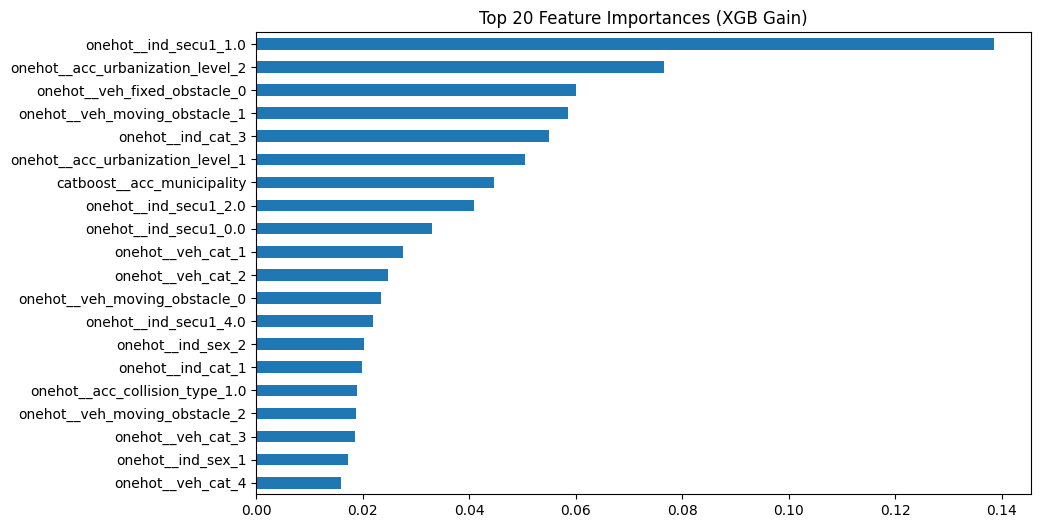

In [25]:
importances = best_xgb.feature_importances_
feat_imp = pd.Series(importances, index=X_train_final.columns)

# Top 20 Features
top20 = feat_imp.sort_values(ascending=False).head(20)

plt.figure(figsize=(10,6))
top20.plot(kind="barh")
plt.title("Top 20 Feature Importances (XGB Gain)")
plt.gca().invert_yaxis()
plt.show()

In [26]:
# Anzahl NaNs pro Spalte
print(X_train_final.isna().sum().sort_values(ascending=False).head(20))
X_train_final = X_train_final.fillna(0)


remainder__loca_road_lanes          6787
cyclical__acc_hour_sin                 0
remainder__ind_location                0
onehot__veh_fixed_obstacle_1           0
onehot__veh_moving_obstacle_0          0
onehot__veh_moving_obstacle_1          0
onehot__veh_moving_obstacle_2          0
onehot__veh_moving_obstacle_3          0
onehot__veh_maneuver_1.0               0
onehot__veh_maneuver_2.0               0
catboost__acc_municipality             0
remainder__ind_trip                    0
remainder__ind_action                  0
onehot__veh_cat_5                      0
remainder__ind_age                     0
remainder__ind_age_group               0
remainder__acc_ambient_lightning       0
remainder__acc_intersection            0
remainder__veh_motor                   0
remainder__loca_road_cat               0
dtype: int64


/var/folders/wg/yhq9d1yx1t1cjky0l7l0d6040000gn/T/ipykernel_52263/936681763.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("viridis", n_classes)


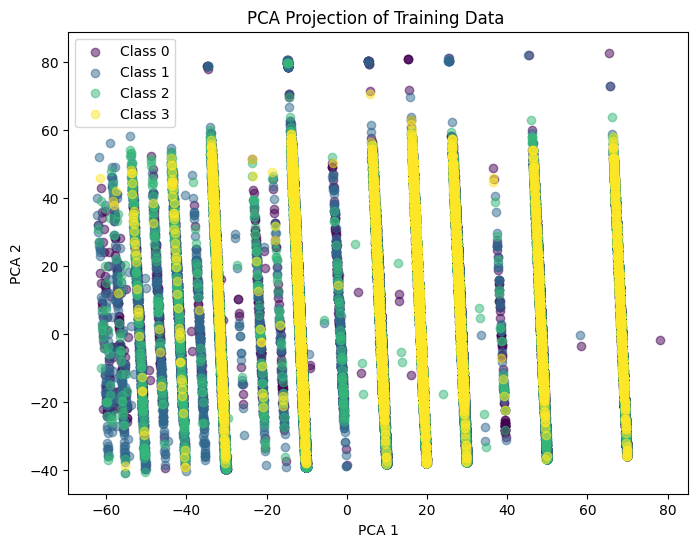

In [27]:
from sklearn.decomposition import PCA

# PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_final)

# define colors
n_classes = len(np.unique(y_train))
cmap = plt.cm.get_cmap("viridis", n_classes)

plt.figure(figsize=(8,6))
for i, cls in enumerate(np.unique(y_train)):
    plt.scatter(
        X_pca[y_train==cls, 0],
        X_pca[y_train==cls, 1],
        label=f"Class {cls}",
        alpha=0.5,
        color=cmap(i)
    )

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Projection of Training Data ")
plt.legend()
plt.show()


PCA 1 explains: 59.38% of variance
PCA 2 explains: 38.80% of variance
Total explained: 98.18%


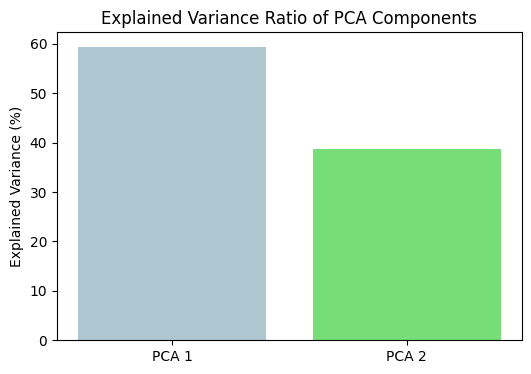

In [28]:
# PCA with 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_final)

# Explained variance ratios
explained_var = pca.explained_variance_ratio_
print(f"PCA 1 explains: {explained_var[0]*100:.2f}% of variance")
print(f"PCA 2 explains: {explained_var[1]*100:.2f}% of variance")
print(f"Total explained: {explained_var.sum()*100:.2f}%")

# Visualization
plt.figure(figsize=(6,4))
plt.bar(range(1, len(explained_var)+1), explained_var*100, color=["#AEC6CF","#77DD77"])
plt.xticks([1,2], ["PCA 1","PCA 2"])
plt.ylabel("Explained Variance (%)")
plt.title("Explained Variance Ratio of PCA Components")
plt.show()

In [29]:
# Create a DataFrame of PCA loadings
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PCA 1", "PCA 2"],
    index=X_train_final.columns
)

# Sort by absolute contribution to PCA 1
top_pca1 = loadings["PCA 1"].abs().sort_values(ascending=False).head(20)
print("Top 20 features contributing to PCA 1:")
print(top_pca1)

# Sort by absolute contribution to PCA 2
top_pca2 = loadings["PCA 2"].abs().sort_values(ascending=False).head(20)
print("\nTop 20 features contributing to PCA 2:")
print(top_pca2)

Top 20 features contributing to PCA 1:
remainder__loca_max_speed           0.997788
remainder__loca_road_cat            0.040445
remainder__ind_age                  0.038363
remainder__loca_road_lanes          0.018692
onehot__acc_urbanization_level_2    0.015905
onehot__acc_urbanization_level_1    0.015905
remainder__ind_action               0.009665
remainder__acc_intersection         0.009084
remainder__ind_location             0.008854
remainder__loca_traffic_circul      0.008052
onehot__ind_secu1_1.0               0.004531
onehot__veh_moving_obstacle_1       0.004115
onehot__acc_collision_type_3.0      0.003586
onehot__veh_cat_1                   0.002772
remainder__veh_motor                0.002769
onehot__veh_moving_obstacle_0       0.002657
onehot__ind_cat_2                   0.002528
catboost__acc_municipality          0.002493
remainder__loca_accident            0.002284
onehot__ind_cat_3                   0.002240
Name: PCA 1, dtype: float64

Top 20 features contributing to 

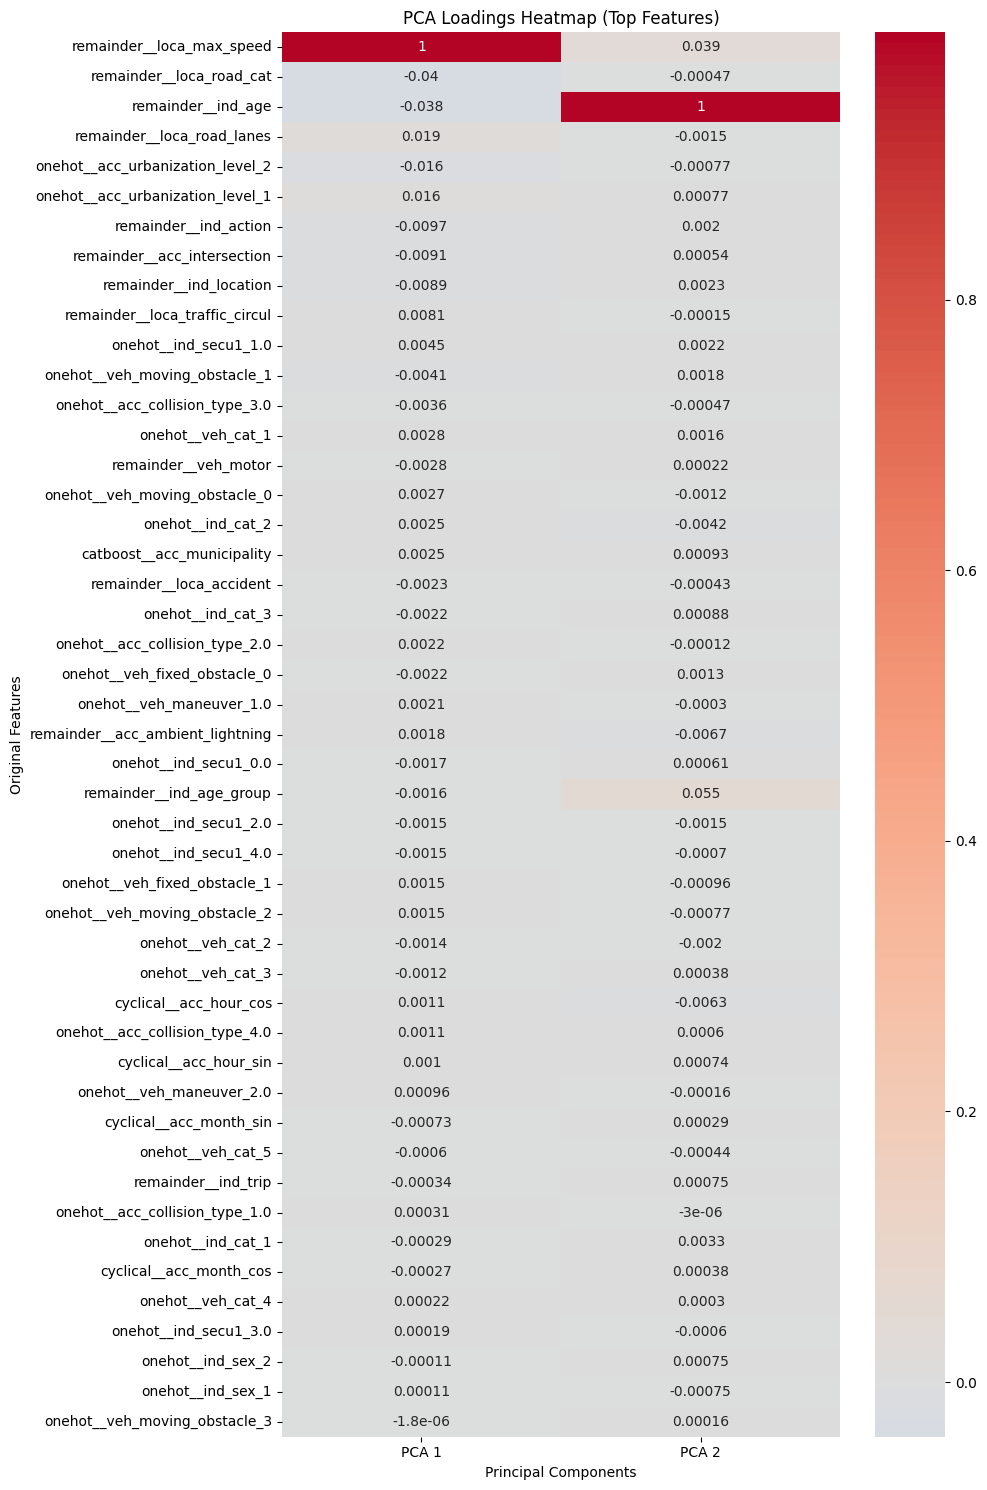

In [434]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_final)

# Create loadings DataFrame
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PCA 1", "PCA 2"],
    index=X_train_final.columns
)

# Optional: sort by PCA 1 contribution
loadings_sorted = loadings.loc[loadings["PCA 1"].abs().sort_values(ascending=False).index]

# Plot heatmap
plt.figure(figsize=(10, max(6, len(loadings_sorted)//3)))
sns.heatmap(loadings_sorted, annot=True, cmap="coolwarm", center=0)
plt.title("PCA Loadings Heatmap (Top Features)")
plt.xlabel("Principal Components")
plt.ylabel("Original Features")
plt.tight_layout()
plt.show()

Top 20 XGB Features by Importance:
                             Feature  Importance
14             onehot__ind_secu1_1.0    0.138647
5   onehot__acc_urbanization_level_2    0.076674
25      onehot__veh_fixed_obstacle_0    0.059977
28     onehot__veh_moving_obstacle_1    0.058610
12                 onehot__ind_cat_3    0.055032
4   onehot__acc_urbanization_level_1    0.050501
33        catboost__acc_municipality    0.044631
15             onehot__ind_secu1_2.0    0.040962
13             onehot__ind_secu1_0.0    0.033024
20                 onehot__veh_cat_1    0.027637
21                 onehot__veh_cat_2    0.024733
27     onehot__veh_moving_obstacle_0    0.023505
17             onehot__ind_secu1_4.0    0.021894
19                 onehot__ind_sex_2    0.020195
10                 onehot__ind_cat_1    0.019885
6     onehot__acc_collision_type_1.0    0.018888
29     onehot__veh_moving_obstacle_2    0.018697
22                 onehot__veh_cat_3    0.018542
18                 onehot__ind_sex

/var/folders/wg/yhq9d1yx1t1cjky0l7l0d6040000gn/T/ipykernel_12023/1689683684.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(20), x="Importance", y="Feature", palette="viridis")


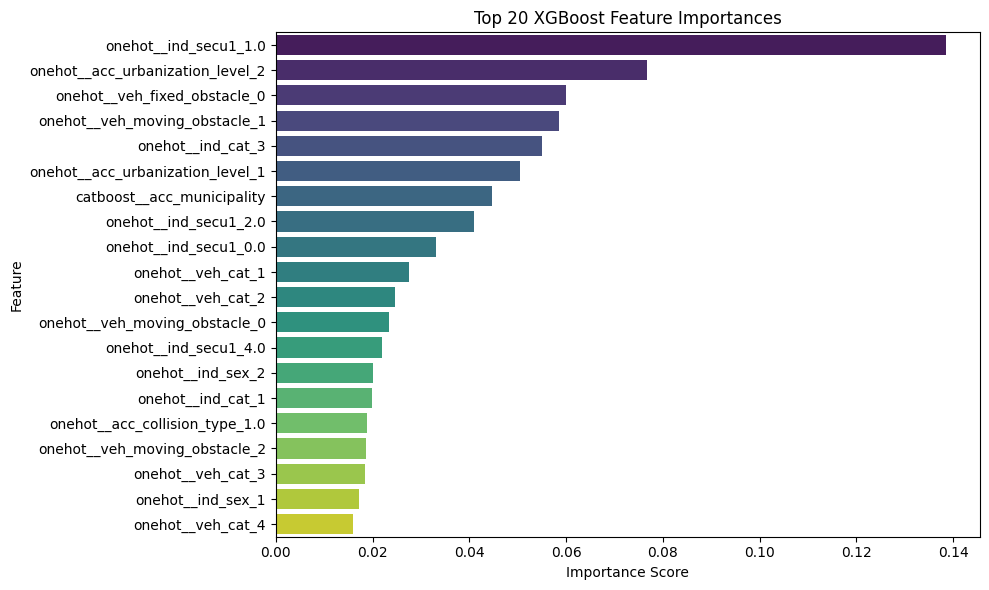

In [435]:
# Extract feature importances
importances = best_xgb.feature_importances_
features = X_train_final.columns

# Create DataFrame
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display top 20
print("Top 20 XGB Features by Importance:")
print(importance_df.head(20))

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(20), x="Importance", y="Feature", palette="viridis")
plt.title("Top 20 XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [436]:

# Fill NaNs if needed
X_train_piped_df_filled = X_train_final.fillna(0)

# Fit PCA with 2 components
pca = PCA(n_components=2)
pca.fit(X_train_piped_df_filled)

# Create loadings DataFrame
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PCA1_Loading", "PCA2_Loading"],
    index=X_train_final.columns
)

# XGB importances
importances = best_xgb.feature_importances_
importance_df = pd.DataFrame({
    "Feature": X_train_final.columns,
    "XGB_Importance": importances
}).set_index("Feature")

# Combine both
combined_df = loadings.join(importance_df)

# Sort by XGB importance
combined_sorted = combined_df.sort_values(by="XGB_Importance", ascending=False)

# Show top 20
print(combined_sorted.head(20))

# show bottom 20
print(combined_sorted.tail(20))

                                  PCA1_Loading  PCA2_Loading  XGB_Importance
onehot__ind_secu1_1.0                 0.004531      0.002207        0.138647
onehot__acc_urbanization_level_2     -0.015905     -0.000775        0.076674
onehot__veh_fixed_obstacle_0         -0.002159      0.001268        0.059977
onehot__veh_moving_obstacle_1        -0.004115      0.001778        0.058610
onehot__ind_cat_3                    -0.002240      0.000878        0.055032
onehot__acc_urbanization_level_1      0.015905      0.000775        0.050501
catboost__acc_municipality            0.002493      0.000929        0.044631
onehot__ind_secu1_2.0                -0.001507     -0.001515        0.040962
onehot__ind_secu1_0.0                -0.001713      0.000607        0.033024
onehot__veh_cat_1                     0.002772      0.001631        0.027637
onehot__veh_cat_2                    -0.001353     -0.002012        0.024733
onehot__veh_moving_obstacle_0         0.002657     -0.001172        0.023505

#baseline:

cols_to_drop1 = [
    "veh_id",
    "acc_date",
    "acc_long",
    "acc_lat",
    "acc_department",
    "acc_year",
    "ind_year",
    "loca_road_counts",
    "loca_max_speed_dif",
    "acc_metro"
]
Train Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.76    200101
           1       0.72      0.53      0.61    196691
           2       0.43      0.47      0.45     74871
           3       0.18      0.72      0.29     12848

    accuracy                           0.63    484511
   macro avg       0.52      0.62      0.53    484511
weighted avg       0.67      0.63      0.64    484511

Test Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75     85758
           1       0.70      0.52      0.60     84296
           2       0.40      0.44      0.42     32087
           3       0.15      0.59      0.24      5507

    accuracy                           0.61    207648
   macro avg       0.50      0.58      0.50    207648
weighted avg       0.66      0.61      0.63    207648

Confusion Matrix (Test):
 [[65350 11283  5293  3832]
 [19705 44045 14366  6180]
 [ 2804  6634 14121  8528]
 [  317   547  1392  3251]]


Takeaway: 
Keep: 
ind_secu1, acc_urbanization, veh_fixed_obstacle, veh_moving_obstacle, veh_cat, ind_cat
seems to be high predictive for severity. 
# 1
cols_to_drop2=[
    "veh_id",
    "acc_date",
    "acc_long",
    "acc_lat",
    "acc_department",
    "acc_year",
    "ind_year",
    "loca_road_counts",
    "loca_max_speed_dif",
    "acc_metro",
    "ind_sex"
]
Train Report:
               precision    recall  f1-score   support

           0       0.74      0.79      0.76    200101
           1       0.72      0.50      0.59    196691
           2       0.43      0.47      0.45     74871
           3       0.18      0.72      0.29     12848

    accuracy                           0.62    484511
   macro avg       0.52      0.62      0.52    484511
weighted avg       0.67      0.62      0.63    484511

Test Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75     85758
           1       0.71      0.50      0.58     84296
           2       0.40      0.44      0.42     32087
           3       0.15      0.59      0.24      5507

    accuracy                           0.61    207648
   macro avg       0.50      0.57      0.50    207648
weighted avg       0.65      0.61      0.62    207648

Confusion Matrix (Test):
 [[66332 10395  5343  3688]
 [21784 42081 14284  6147]
 [ 2873  6610 14010  8594]
 [  315   557  1391  3244]]

 Takeaway: Removing ind_sex shows no significant changes. 

 # 2 
 cols_to_drop2=[
    "veh_id",
    "acc_date",
    "acc_long",
    "acc_lat",
    "acc_department",
    "acc_year",
    "ind_year",
    "loca_road_counts",
    "loca_max_speed_dif",
    "acc_metro"
]
  based  tail (20):
 modalities_to_drop = [
    "onehot__veh_impact_1.0",
    "onehot__veh_impact_0.0",
    "onehot__veh_maneuver_4.0",
    "onehot__veh_maneuver_5.0",
    "onehot__veh_maneuver_6.0",
    "cyclical__acc_hour_cos",
    "cyclical__acc_hour_sin",
    "cyclical__acc_month_cos",
    "cyclical__acc_month_sin",
    "remainder__acc_intersection",
    "remainder__ind_action",
    "remainder__loca_road_lanes",
    "remainder__ind_location",
    "remainder__ind_trip",
    "remainder__loca_road_view",
    "remainder__acc_atmosphere",
    "remainder__loca_road_gradient",
    "remainder__loca_road_surface_cond",
    "remainder__loca_is_intersection",
    "remainder__ind_secu2"
]
Train Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.76    200101
           1       0.71      0.52      0.60    196691
           2       0.42      0.46      0.44     74871
           3       0.17      0.68      0.27     12848

    accuracy                           0.62    484511
   macro avg       0.51      0.61      0.52    484511
weighted avg       0.67      0.62      0.63    484511

Test Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75     85758
           1       0.70      0.52      0.60     84296
           2       0.40      0.44      0.42     32087
           3       0.14      0.58      0.23      5507

    accuracy                           0.61    207648
   macro avg       0.50      0.58      0.50    207648
weighted avg       0.66      0.61      0.62    207648

Confusion Matrix (Test):
 [[65504 11125  5142  3987]
 [20003 43632 14297  6364]
 [ 2846  6595 14031  8615]
 [  328   553  1420  3206]]
# 3
same cols_to_drop and modalities to drop like attempt # 2 but added reg_alpha as new parameter for xgb
Train Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.76    200101
           1       0.71      0.52      0.60    196691
           2       0.42      0.46      0.44     74871
           3       0.17      0.68      0.27     12848

    accuracy                           0.62    484511
   macro avg       0.51      0.61      0.52    484511
weighted avg       0.67      0.62      0.63    484511

Test Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75     85758
           1       0.70      0.52      0.60     84296
           2       0.40      0.43      0.42     32087
           3       0.14      0.58      0.23      5507

    accuracy                           0.61    207648
   macro avg       0.50      0.57      0.50    207648
weighted avg       0.66      0.61      0.62    207648

# 4
cols_to_drop3 = [
    "veh_id",
    "acc_date",
    "acc_long",
    "acc_lat",
    "acc_department",
    "acc_year",
    "ind_year",
    "loca_road_counts",
    "loca_max_speed_dif",
    "acc_metro",

    "acc_municipality",
    "veh_motor",
    "acc_hour",
    "acc_month",

]
reg_alpha as parameter
no modalities dropped
Train Report:
               precision    recall  f1-score   support

           0       0.74      0.77      0.76    200101
           1       0.70      0.48      0.57    196691
           2       0.38      0.42      0.40     74871
           3       0.15      0.68      0.24     12848

    accuracy                           0.59    484511
   macro avg       0.49      0.59      0.49    484511
weighted avg       0.65      0.59      0.61    484511

Test Report:
               precision    recall  f1-score   support

           0       0.74      0.77      0.76     85758
           1       0.69      0.47      0.56     84296
           2       0.37      0.41      0.39     32087
           3       0.14      0.65      0.23      5507

    accuracy                           0.59    207648
   macro avg       0.49      0.58      0.48    207648
weighted avg       0.65      0.59      0.61    207648
takeaway: dropped columns are too important to drop. (decrease of scores)
# 5
cols_to_drop4 = [
    "veh_id",
    "acc_date",
    "acc_long",
    "acc_lat",
    "acc_department",
    "acc_year",
    "ind_year",
    "loca_road_counts",
    "loca_max_speed_dif",
    "acc_metro",

    "ind_place",
    "veh_impact",

]
worst modalities of attempt 4 dropped: 
modalities_to_drop2 = [
    "onehot__veh_maneuver_3.0",
    "onehot__veh_maneuver_4.0",
    "onehot__veh_maneuver_5.0",
    "onehot__veh_maneuver_6.0",
    "onehot__veh_cat_6",
    "onehot__veh_fixed_obstacle_2",
    "remainder__loca_road_view",
    "remainder__loca_road_gradient",
    "remainder__loca_road_surface_cond",
    "remainder__acc_atmosphere",
    "remainder__loca_is_intersection",
    "remainder__ind_secu2"
]
reg_alpha set
Train Report:
               precision    recall  f1-score   support

           0       0.75      0.77      0.76    200101
           1       0.71      0.52      0.60    196691
           2       0.42      0.46      0.44     74871
           3       0.17      0.70      0.27     12848

    accuracy                           0.62    484511
   macro avg       0.51      0.61      0.52    484511
weighted avg       0.67      0.62      0.63    484511

Test Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75     85758
           1       0.70      0.52      0.60     84296
           2       0.40      0.43      0.42     32087
           3       0.14      0.58      0.23      5507

    accuracy                           0.61    207648
   macro avg       0.49      0.57      0.50    207648
weighted avg       0.65      0.61      0.62    207648

Confusion Matrix (Test):
 [[64873 11552  5260  4073]
 [19971 43745 14162  6418]
 [ 2843  6664 13907  8673]
 [  326   556  1441  3184]]

# 6
cols_to_drop4 = [
    "veh_id",
    "acc_date",
    "acc_long",
    "acc_lat",
    "acc_department",
    "acc_year",
    "ind_year",
    "loca_road_counts",
    "loca_max_speed_dif",
    "acc_metro",

    "ind_place",
    "veh_impact",

    "ind_age",
    "ind_sex",
    "veh_motor",
    "acc_month",

]
# evalution


# Experimentation Log

# Experimentation Log

| Iteration | Change Applied | Recall (class3) | F1 Macro | Notes |
|-----------|----------------|-----------------------|----------|-------|
| Baseline  | cols_to_drop1|0.72 |0.53 | Starting point | baseline from RandomForrest classifier( notebook 1.8.3-..)
| 1         | cols_to_drop2 |  0.72|0.52 | removed ind_sex | no significant changes.
| 2         | cols_to_drop1/modalities dropped | 0.68 | 0.52 | recall dropped/no improvement |
| 3         | as attempt 2, just added reg_alpha as param | 0.68 | 0.52 | no changes |
| 4         | cols_to_drop3 | 0.68 | 0.49 | decreased f1 macro |
| 5         | cols_to_drop4/modalities_to_drop2 | 0.70 | 0.52 | no improvement towards baseline but better than attempt 3 and 4 |
| 6         | … | … | … | … |
| 7         | … | … | … | … |
| 8         | … | … | … | … |
| 9         | … | … | … | … |
| 10        | … | … | … | … |
| 11        | … | … | … | … |
| 12        | … | … | … | … |
| 13        | … | … | … | … |
| 14        | … | … | … | … |
| 15        | … | … | … | … |
| 16        | … | … | … | … |
| 17        | … | … | … | … |
| 18        | … | … | … | … |
| 19        | … | … | … | … |

In [30]:
dump(best_xgb, "xgb_multiclass.joblib")

['xgb_multiclass.joblib']